In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import time
import PIL
from tqdm import tqdm
from PIL  import ImageDraw, ImageFont, Image
%matplotlib inline

In [2]:
def undistort_image(image, mtx, dist):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.undistort(image, mtx, dist, None, mtx)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def Calibrate_camera(nx, ny, Filename):
    
    #read calibration images
    images = glob.glob(Filename)
    # Arrays to store object points and image points from all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane
    #prepare object points
    objp = np.zeros((ny*nx,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x, y coordinates
    print('processing images: ')
    # iterate on every image to collect point for calibration
    for image in tqdm(images):

        # read each image
        img = mpimg.imread(image)

        #convert image to gray scale
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        #find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        #If cornersare found add object points and image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

def wrap_image(img,src,dst):

    # Grab the image shape
    img_size = []
    if len(img.shape) == 3:
        img_size = img.shape[::-1][1:3]
    else:
        img_size = img.shape[::-1]
    # For source points I'm grabbing the outer four detected corners

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel))
    if orient == 'y':
        sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel))
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaledImg = np.uint8(255*sobel/np.max(sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
        # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaledImg)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaledImg >= thresh[0]) & (scaledImg <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = np.power(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel), 2)
    sobely = np.power(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel), 2)
    # 3) Calculate the magnitude 
    sobel = np.sqrt(sobelx + sobely)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaleSobel = np.uint8(255*sobel/np.max(sobel))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaleSobel)
    mag_binary[(scaleSobel >= mag_thresh[0]) & (scaleSobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mag_binary
   
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the image in x and y separately
    sobelx = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel))
    # 3) Calculate the magnitude 
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sobelangle = np.arctan2(sobely,sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(sobelangle)
    dir_binary[(sobelangle >= thresh[0]) & (sobelangle <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return dir_binary
    
def colorSpace_select(img, channel ,colortype , thresh=(0, 255)):
    if colortype == 'HLS':
        # 1) Convert to HLS color space
        ColorSpace = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if colortype == 'HSV':
        # 1) Convert to HSV color space
        ColorSpace = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # 2) Apply a threshold to the S channel
    channel = ColorSpace[:,:,channel]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

# Load our image
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 20
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    margin = 100
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    #calculate the left and right curverature angle
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fitx, right_fitx)
    
    return left_curverad, right_curverad, left_fitx, right_fitx, ploty

def measure_curvature_real(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fit*xm_per_pix , 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fit*xm_per_pix , 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
   
    return left_curverad, right_curverad

processing images: 


100%|██████████████████████████████████████████| 18/18 [00:02<00:00,  6.65it/s]


 
Calibration has finished


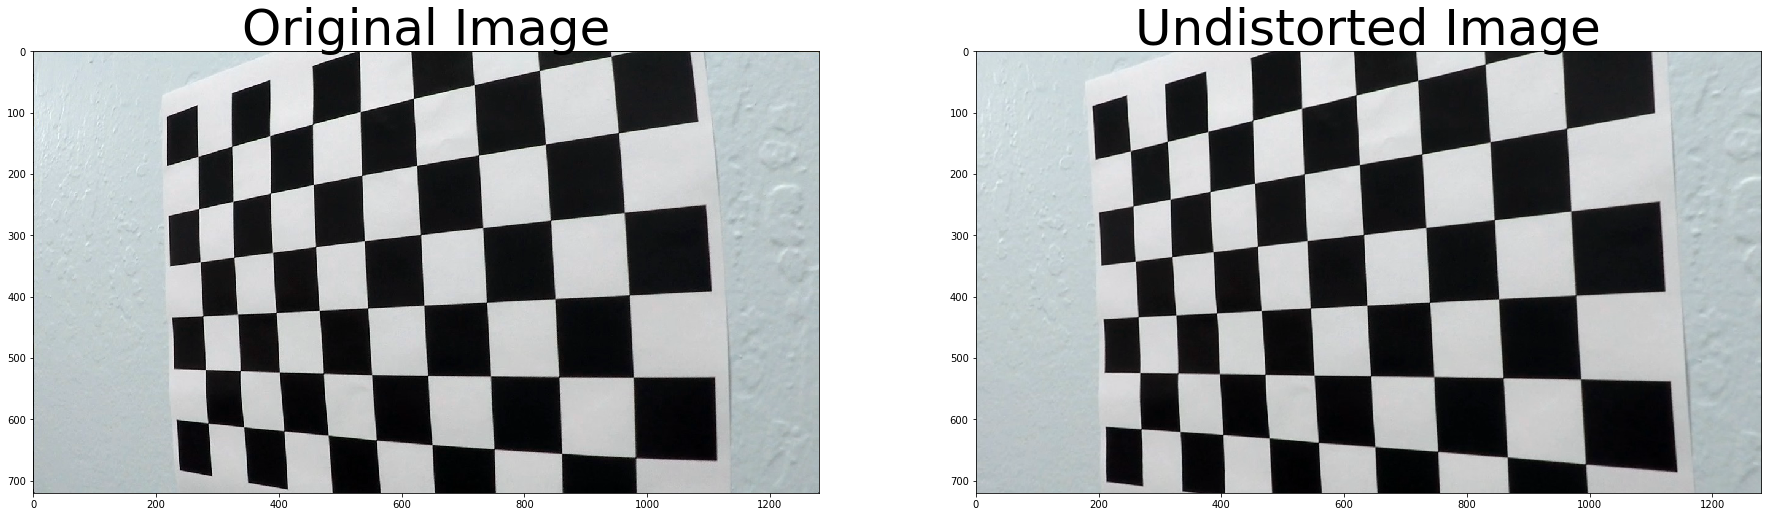

In [3]:
# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

Filename = 'camera_cal/calibration*.jpg'

ret, mtx, dist, rvecs, tvecs = Calibrate_camera(nx, ny, Filename)

print(' \nCalibration has finished')
img = cv2.imread('camera_cal/calibration4.jpg')

undistorted = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [9]:
def process_image(image):
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements
    offset = 200 # clearness between left and right borders
    img_size = image.shape
    HLS_thresh = (100, 255)
    HSV_thresh = (220, 255)
    X_thresh = (30, 70)

    undistorted = undistort_image(image, mtx, dist)
    gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)

    # Apply each of the thresholding functions
    s_hls = colorSpace_select(undistorted, channel=2, colortype='HLS', thresh=HLS_thresh)
    v_hsv = colorSpace_select(undistorted, channel=2, colortype='HSV', thresh=HSV_thresh)
    x_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=X_thresh)

    #create a combinations of color and gradient thresholds
    combined = np.zeros_like(gray)
    combined[((v_hsv == 1)| x_binary==1  |  (s_hls == 1))] = 1

    
    src = np.float32([[585, 460 ], [203, 720], [1127, 720], [695, 460]])

    # again, not exact, but close enough for our purposes
    dst = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])
    
    
    src = np.float32([[1000,650], [300,650], [578,460], [704,460]])

    dst = np.float32([[1000,700], [200, 700], [200,0], [1000,0]])
    
    #focus on the road area only by channging preception
    wraped_combined = wrap_image(combined,src,dst)[0]
    Minv = wrap_image(combined,dst,src)[1]
    
    left_curverad, right_curverad, left_fitx, right_fitx, ploty = fit_polynomial(wraped_combined)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(wraped_combined).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    

    # Add value for the 
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 3
    text                   = "Raduis of Curvature = "
    
    result = cv2.putText(result, text, (100,100), font, fontScale, fontColor, lineType)
    result = cv2.putText(result, str(int(left_curverad)), (850,100), font, fontScale, fontColor, lineType)
    
    return result

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_images/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format(white_output))

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [02:51<00:00,  7.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

Wall time: 2min 52s
